# Create Neo4j Database

### Retrieve Required Data

In [199]:
import pandas as pd
import pickle
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
def normalize_text(text):
    # Lowercase every words
    text = text.lower()
    # Get rid of the punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Get rid of these specific punctuations
    text = re.sub('[‘’“”…]', '', text)
    # Get rid of '\n'
    text = re.sub('\n', '', text)
    return text

In [3]:
# User comedian matrix
matrix_filename = 'user_comedian_matrix_OriginalPolarity.pkl'
ucm_df = pd.read_pickle(matrix_filename)
ucm_df.index = [normalize_text(t) for t in ucm_df.index]
ucm_df.columns = [normalize_text(t) for t in ucm_df.columns]
ucm_df

,ramy youssef,andy woodhull,amy schumer,arsenio hall,aziz ansari,bert kreischer,bill burr,chris delia,chris rock,dave chappelle,...,ronny chieng,roy wood jr,russell peters,sebastian maniscalco,tiffany haddish,tom segura,trevor noah,urzila carlson,vir das,whitney cummings
a b,0.191429,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
adedotun akande,NaN,0.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.4,NaN,-0.1625,NaN,NaN,NaN,NaN,NaN,NaN
anton nym,NaN,0.68099,NaN,NaN,NaN,0,NaN,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lydia wawerumorgan,NaN,-0.2375,NaN,0.65,NaN,0.488281,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jennifer bates,NaN,0.671875,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
camthedestroyer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jay jay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.155,NaN,NaN,NaN,NaN,0.8,NaN,NaN,NaN,NaN
cynthia copland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.3,NaN,NaN,NaN,NaN,NaN
comedy central standup comedy central standup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.268182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5


In [4]:
# Training set
train_df = pd.read_csv('training_set.csv', index_col=0)
train_df.Name = train_df.Name.apply(normalize_text)
train_df.Comedian = train_df.Comedian.apply(normalize_text)
train_df['Rating'] = [ucm_df.loc[u, c] for u, c in zip(train_df.Name.values, train_df.Comedian.values)]
train_df

,Name,Comedian,Rating
0,a b,ramy youssef,0.191429
1,a b,vir das,0.000000
2,adedotun akande,sebastian maniscalco,-0.162500
3,adedotun akande,andy woodhull,0.875000
4,anton nym,bert kreischer,0.000000
...,...,...,...
175,cynthia copland,pete davidson,0.291667
176,comedy central standup comedy central...,whitney cummings,0.500000
177,comedy central standup comedy central...,pete davidson,0.268182
178,michelle mcfarland,tiffany haddish,0.000000


In [77]:
# Test set
test_df = pd.read_csv('test_set.csv', index_col=0)
test_df.Name = test_df.Name.apply(normalize_text)
test_df.Comedian = test_df.Comedian.apply(normalize_text)
test_df['Rating'] = [ucm_df.loc[u, c] for u, c in zip(test_df.Name.values, test_df.Comedian.values)]
test_df

,Name,Comedian,Rating
0,a b,chris delia,0.000000
1,adedotun akande,roy wood jr,0.400000
2,anton nym,chris rock,0.000000
3,lydia wawerumorgan,arsenio hall,0.650000
4,jennifer bates,pete davidson,0.277381
...,...,...,...
75,camthedestroyer,kevin hart,-0.291667
76,jay jay,kevin hart,0.200000
77,cynthia copland,michelle wolf,-0.187500
78,comedy central standup comedy central...,roy wood jr,0.268182


In [6]:
test_df[~test_df.Comedian.isin(train_df.Comedian.unique())]

,Name,Comedian,Rating


In [34]:
# Comedian Properties
cp_df = pd.read_excel('ComedianProperties.xlsx')
# Categorize the year of birth of the comedians
cp_df['year group'] = cp_df.year.apply(lambda x: str(x)[:3]+'0s')
# Remove unnecessary columns
cp_df = cp_df.drop(['spouseLabel','children_number','birthdate','year'], axis=1)
# change column names
cp_df.columns = ['Comedian','Citizenship','Ethnicity','Married','Gender','Year']
# Numerize Married Column
cp_df.Married = cp_df.Married.apply(lambda x: int(x))
# Normalize comedian names
cp_df.Comedian = cp_df['Comedian'].apply(normalize_text)
# Set index to comedian
cp_df = cp_df.set_index(cp_df['Comedian'])
# Drop Comedian Column
cp_df = cp_df.drop('Comedian', axis=1)
cp_df.head()

,Citizenship,Ethnicity,Married,Gender,Year
Comedian,,,,,
andy woodhull,United States of America,White,1,male,1980s
ramy youssef,United States of America,Egyptian-American Muslim,0,male,1990s
amy schumer,United States of America,American Jews,1,female,1980s
arsenio hall,United States of America,African Americans,0,male,1950s
aziz ansari,United States of America,Tamil American,0,male,1980s


In [36]:
cp_dummy = pd.get_dummies(cp_df, drop_first=True)
cp_dummy.head()

,Married,Citizenship_Canada,Citizenship_India,Citizenship_New Zealand,Citizenship_People's Republic of China,Citizenship_Philippines,Citizenship_South Africa,Citizenship_United Kingdom,Citizenship_United States of America,Ethnicity_American Jews,...,Ethnicity_Tamil American,Ethnicity_White,"Ethnicity_ Irish, Ashkenazi Jewish, Italian, German, Scottish, English","Ethnicity_ Irish, German",Gender_male,Year_1950s,Year_1960s,Year_1970s,Year_1980s,Year_1990s
Comedian,,,,,,,,,,,,,,,,,,,,,
andy woodhull,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
ramy youssef,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
amy schumer,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
arsenio hall,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
aziz ansari,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0


In [8]:
# Comedian & keywords
kw_df = pd.read_excel('keywords_clean.xlsx',index_col=0)
kw_df.Comedian = kw_df.Comedian.apply(normalize_text)
kw_df.head()

,Comedian,Keywords
0,amy schumer,"grow, grows, arrested, schumers, schumer, butt..."
1,andy woodhull,"toast, maze, punishing, punishment, ordered pu..."
2,arsenio hall,"wesley, marching, tiger, grow, plus, bernie, a..."
3,aziz ansari,"randy, randys, harris, texted, writing, writes..."
4,bert kreischer,"marshmallow, leeann, ilas, pajama, glock, leea..."


In [9]:
# Users and Comedians 
users = train_df.Name.unique()
comedians = train_df.Comedian.unique()

### Build the graph in neo4j

In [10]:
from py2neo import Graph, Node, Relationship

In [11]:
host = "localhost"
password = "0000"
graph = Graph(host=host, password=password)

In [12]:
# Delete all nodes and relationships
DELETE_QUERY = "MATCH (n) DETACH DELETE n"
_ = graph.run(DELETE_QUERY)

In [13]:
# Add all user nodes
for user in users:
    graph.run("""
    MERGE (:User{name: $user})
    """, user=user)

In [14]:
# Add all comedian nodes
for comedian in comedians:
    properties = cp_df.loc[comedian]
    graph.run("""
    MERGE (:Comedian{name: $comedian, 
                      ethnicity: $ethnicity,
                      married: $married,
                      gender: $gender,
                      year: $year})
        """,comedian=comedian,
            citizenship=properties['Citizenship'],
            ethnicity=properties['Ethnicity'],
            married=int(properties['Married']),
            gender=properties['Gender'],
            year=properties['Year'])

In [15]:
# Build relationships for users and comedians
for k, v in train_df.iterrows():
    u = v['Name']
    c = v['Comedian']
    rating = v['Rating']
    if rating != 'NaN':
        if rating > 0:
            # if rating is positive, add more link to make it closer to the comedian 
            for i in range(5):
                graph.run("""
                MATCH (u:User{name: $user})
                MATCH (c:Comedian{name: $comedian})
                MERGE (u)-[r:commented_on{rating: $rr, index: $id}]->(c)""", user=u, comedian=c, rr=rating, id=i)
        else:
            graph.run("""
            MATCH (u:User{name: $user})
            MATCH (c:Comedian{name: $comedian})
            MERGE (u)-[r:commented_on{rating: $rr, index:1}]->(c)""", user=u, comedian=c, rr=rating)

In [16]:
# Add all keyword nodes
for i, r in kw_df.iterrows():
    comedian = r.Comedian
    keywords = r.Keywords.split(',')
    for word in keywords:
        graph.run("""
        MERGE (k:Keyword{word: $word})
        """, word=word)
        graph.run("""
        MATCH (c:Comedian{name: $comedian})
        MATCH (k:Keyword{word: $word})
        MERGE (c)-[:has_keyword]->(k)""", comedian=comedian, word=word)

# Clustering

In [18]:
from igraph import Graph as IGraph

In [19]:
# query="""
# MATCH (k1:Keyword)<-[:has_keyword]-()-[:has_keyword]->(k2:Keyword)
# WHERE ID(k1) < ID(k2)
# RETURN k1.word, k2.word, COUNT(*) as weight
# ORDER BY weight DESC
# LIMIT 10
# """

# result = graph.run(query)
# for row in result:
#     print(row)

' shes'	' fucking'	22
' shes'	' thanks'	21
' shes'	' life'	21
' thanks'	' fucking'	21
' fucking'	' kid'	20
' fucking'	' life'	20
' fucking'	' person'	19
' work'	' person'	19
' thanks'	' work'	19
' woman'	' everybody'	19


In [19]:
# query = """
# MATCH (k1:Keyword)<-[:has_keyword]-()-[:has_keyword]->(k2:Keyword)
# WHERE ID(k1) < ID(k2)
# RETURN k1.word, k2.word, COUNT(*) as weight
# """

query="""
MATCH (u1:User)-[:commented_on]->()<-[:commented_on]->(u2:User)
WHERE ID(u1) < ID(u2)
RETURN u1.name, u2.name, COUNT(*) as weight
ORDER BY weight DESC
"""

ig = IGraph.TupleList(graph.run(query), weights=True)
ig

In [20]:
clusters = IGraph.community_walktrap(ig, weights="weight")
clusters = clusters.as_clustering()
len(clusters)

12

In [21]:
nodes = [node["name"] for node in ig.vs]
nodes = [{"id": x, "label": x} for x in nodes]
nodes[:5]

for node in nodes:
    idx = ig.vs.find(name=node["id"]).index
    node["group"] = clusters.membership[idx]
    
nodes[:5]

[{'id': 'adedotun akande', 'label': 'adedotun akande', 'group': 0},
 {'id': 'r a', 'label': 'r a', 'group': 0},
 {'id': 'babychaingang', 'label': 'babychaingang', 'group': 1},
 {'id': 'mike jones', 'label': 'mike jones', 'group': 1},
 {'id': 'green envy', 'label': 'green envy', 'group': 2}]

In [22]:
# pickle.dump(nodes, open('keyword_group.pkl', 'wb'))
pickle.dump(nodes, open('user_group.pkl', 'wb'))

# Prediction

In [23]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [24]:
# Load training and test dataset
train_df = pd.read_csv('training_set.csv', index_col=0)
test_df = pd.read_csv('test_set.csv', index_col=0)

In [25]:
train_df.Name = train_df.Name.apply(normalize_text)
train_df.Comedian = train_df.Comedian.apply(normalize_text)
test_df.Name = test_df.Name.apply(normalize_text)
test_df.Comedian = test_df.Comedian.apply(normalize_text)

### Apply node2vec

In [27]:
query = "CALL gds.graph.drop('MyGraph')"
graph.run(query)

query = "CALL gds.graph.create('MyGraph', '*', '*')"
graph.run(query)

 nodeProjection                          | relationshipProjection                                                                 | graphName | nodeCount | relationshipCount | createMillis 
-----------------------------------------|----------------------------------------------------------------------------------------|-----------|-----------|-------------------|--------------
 {__ALL__: {properties: {}, label: '*'}} | {__ALL__: {orientation: 'NATURAL', aggregation: 'DEFAULT', type: '*', properties: {}}} | MyGraph   |      6363 |              9005 |           40 

In [37]:
query="""
CALL gds.alpha.node2vec.stream(
'MyGraph',
{
  returnFactor: 1.0, // parameter 'p'
  inOutFactor: 2.0,  // parameter 'q'
  embeddingSize: 16  // parameter 'd'
})"""

embedding_df = graph.run(query).to_data_frame()
embedding_df = embedding_df.set_index('nodeId')
embedding_df.head()

,embedding
nodeId,
0,"[-0.041628822684288025, -0.3119439482688904, 0..."
1,"[-0.24572719633579254, -0.5136674046516418, -0..."
2,"[-0.9943878650665283, 0.9283894300460815, 0.34..."
3,"[-0.9982753992080688, -0.21847844123840332, 0...."
4,"[0.8300057053565979, 0.7800081372261047, -0.60..."


In [38]:
def get_embedding(node_id):
    return embedding_df.loc[node_id][0]

### Lookup node ids and relationships

In [39]:
# Retrieve comedian-id lookup table
query = "MATCH (n:Comedian) RETURN ID(n) as c_id, n.name as name"

comedianID_df = graph.run(query).to_data_frame()
comedianID_df.head()

,c_id,name
0,6560,ramy youssef
1,6561,vir das
2,6562,sebastian maniscalco
3,6563,andy woodhull
4,6564,bert kreischer


In [40]:
# Retrieve user-id lookup table
query = "MATCH (n:User) RETURN ID(n) as u_id, n.name as name"

userID_df = graph.run(query).to_data_frame()
userID_df.head()

,u_id,name
0,651,a b
1,652,adedotun akande
2,6483,anton nym
3,6484,lydia wawerumorgan
4,6485,jennifer bates


In [41]:
# Transplate the names in the dataset into id
for k, v in train_df.iterrows():
    user = v['Name']
    com = v['Comedian']
    train_df.iloc[k, 0] = userID_df[userID_df.name == user].u_id.values[0]
    train_df.iloc[k, 1] = comedianID_df[comedianID_df.name == com].c_id.values[0]
    
for k, v in test_df.iterrows():
    user = v['Name']
    com = v['Comedian']
    test_df.iloc[k, 0] = userID_df[userID_df.name == user].u_id.values[0]
    test_df.iloc[k, 1] = comedianID_df[comedianID_df.name == com].c_id.values[0]

In [86]:
# query all user-comedian id relationships and ratings
query = """
MATCH (u:User)-[r:commented_on]->(c:Comedian)
WHERE r.index = 1
RETURN ID(u) as u_id, ID(c) as c_id, r.rating as y
"""
ucID_df = graph.run(query).to_data_frame()
ucID_df

,u_id,c_id,y
0,651,6560,0.191429
1,651,6561,0.000000
2,6496,6561,0.000000
3,6502,6561,0.000000
4,6503,6561,0.000000
...,...,...,...
175,6544,6596,0.175325
176,6548,6596,0.000000
177,6544,6597,0.200000
178,6549,6598,0.156250


In [47]:
# query all comedian-keyword id relationships
query = """
MATCH (c:Comedian)-[:has_keyword]->(k:Keyword)
WHERE ID(c) = $comedian_id
RETURN ID(c) as c_id, COLLECT(DISTINCT ID(k)) as k_id
"""
ckID_df = pd.DataFrame(columns=['c_id','k_id']) 
for cid in comedianID_df.c_id:
    result = graph.run(query, comedian_id=cid)
    for k, v in result:
        ckID_df = ckID_df.append({'c_id': k, 'k_id':v}, ignore_index=True)

In [48]:
len(ckID_df.c_id.unique())

40

In [49]:
# calculate the centroid of keywords for each 
k_centroid = []
for k, v in ckID_df.iterrows():
    vector = None
    for k_id in v['k_id']:
        if vector is None:
            vector = get_embedding(k_id)
        else:
            vector = np.add(get_embedding(k_id), vector)
    k_centroid.append(np.divide(vector, len(v['k_id'])))
ckID_df['k_centroid'] = k_centroid
ckID_df.head()

,c_id,k_id,k_centroid
0,6560,"[11851, 11818, 11819, 11820, 8188, 11821, 1171...","[-0.05429070195912019, 0.041987864401839346, 0..."
1,6561,"[7625, 9032, 8609, 11604, 522, 10794, 9498, 70...","[-0.027223640046006924, -0.08530084516534263, ..."
2,6562,"[66, 7412, 11102, 10417, 6701, 7672, 8095, 65,...","[-0.005493441937804812, -0.03349331681994666, ..."
3,6563,"[6854, 6853, 6852, 6851, 6850, 6849, 6848, 684...","[-0.016451625193914642, 0.08487939786003984, -..."
4,6564,"[7302, 7301, 7300, 7299, 7298, 7297, 7296, 729...","[-0.026089010479557792, -0.020107248719374568,..."


In [66]:
# append one-hot encoding comedian properties to the matrix
c2= cp_dummy.copy()
c2["c_id"] = c2.index
c2["c_id"] = c2["c_id"].apply(lambda x: comedianID_df[comedianID_df.name==x].c_id.values[0])
ckID_merge = ckID_df.merge(c2, on='c_id')
ckID_merge.head()

,c_id,k_id,k_centroid,Married,Citizenship_Canada,Citizenship_India,Citizenship_New Zealand,Citizenship_People's Republic of China,Citizenship_Philippines,Citizenship_South Africa,...,Ethnicity_Tamil American,Ethnicity_White,"Ethnicity_ Irish, Ashkenazi Jewish, Italian, German, Scottish, English","Ethnicity_ Irish, German",Gender_male,Year_1950s,Year_1960s,Year_1970s,Year_1980s,Year_1990s
0,6560,"[11851, 11818, 11819, 11820, 8188, 11821, 1171...","[-0.05429070195912019, 0.041987864401839346, 0...",0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,6561,"[7625, 9032, 8609, 11604, 522, 10794, 9498, 70...","[-0.027223640046006924, -0.08530084516534263, ...",1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,6562,"[66, 7412, 11102, 10417, 6701, 7672, 8095, 65,...","[-0.005493441937804812, -0.03349331681994666, ...",0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,6563,"[6854, 6853, 6852, 6851, 6850, 6849, 6848, 684...","[-0.016451625193914642, 0.08487939786003984, -...",1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
4,6564,"[7302, 7301, 7300, 7299, 7298, 7297, 7296, 729...","[-0.026089010479557792, -0.020107248719374568,...",0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


In [87]:
def create_dataset(df, user_comedian_df):   
    # Merger this selected df with the ckID_df to append k_centroid
    merge_k_centroid = user_comedian_df.merge(ckID_merge,on='c_id')
    merge_k_centroid = merge_k_centroid.drop('k_id', axis=1)
    
    # Translate u_id and c_id to embedding
    merge_k_centroid.u_id = merge_k_centroid.u_id.apply(get_embedding)
    merge_k_centroid.c_id = merge_k_centroid.c_id.apply(get_embedding)
    
    # Expend all embeddings to columns
    temp_u = merge_k_centroid.u_id.apply(pd.Series)
    temp_u = temp_u.rename(columns = lambda x : 'u' + str(x))
    temp_c = merge_k_centroid.c_id.apply(pd.Series)
    temp_c = temp_c.rename(columns = lambda x : 'c' + str(x))
    temp_k = merge_k_centroid.k_centroid.apply(pd.Series)
    temp_k = temp_k.rename(columns = lambda x : 'k' + str(x))
    
    dataset = pd.concat([merge_k_centroid, temp_u[:], temp_c[:], temp_k[:]], axis=1)
    dataset = dataset.drop(['u_id','c_id','k_centroid'], axis=1)
    return dataset    

In [88]:
train_dataset = create_dataset(train_df, ucID_df)
train_dataset.to_pickle('train_dataset.pkl')
train_dataset

,y,Married,Citizenship_Canada,Citizenship_India,Citizenship_New Zealand,Citizenship_People's Republic of China,Citizenship_Philippines,Citizenship_South Africa,Citizenship_United Kingdom,Citizenship_United States of America,...,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,0.191429,0,0,0,0,0,0,0,0,1,...,-0.109202,0.035659,0.061705,0.003643,0.049141,-0.143553,0.051251,0.002531,0.228867,-0.036256
1,0.000000,1,0,1,0,0,0,0,0,0,...,-0.074969,-0.068368,-0.093736,0.012557,-0.044266,-0.006748,-0.061262,0.010832,-0.054845,-0.080655
2,0.000000,1,0,1,0,0,0,0,0,0,...,-0.074969,-0.068368,-0.093736,0.012557,-0.044266,-0.006748,-0.061262,0.010832,-0.054845,-0.080655
3,0.000000,1,0,1,0,0,0,0,0,0,...,-0.074969,-0.068368,-0.093736,0.012557,-0.044266,-0.006748,-0.061262,0.010832,-0.054845,-0.080655
4,0.000000,1,0,1,0,0,0,0,0,0,...,-0.074969,-0.068368,-0.093736,0.012557,-0.044266,-0.006748,-0.061262,0.010832,-0.054845,-0.080655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.175325,0,0,0,0,0,0,0,0,1,...,0.007590,-0.007681,-0.001397,0.051224,-0.034508,-0.094676,-0.034771,-0.047515,0.025450,0.062095
176,0.000000,0,0,0,0,0,0,0,0,1,...,0.007590,-0.007681,-0.001397,0.051224,-0.034508,-0.094676,-0.034771,-0.047515,0.025450,0.062095
177,0.200000,0,0,0,0,0,0,1,0,0,...,0.005973,-0.004308,-0.028627,0.004967,-0.024404,-0.020084,0.099232,-0.021327,-0.030075,0.024714
178,0.156250,1,1,0,0,0,0,0,0,0,...,-0.055982,0.046342,0.031989,-0.001134,-0.014343,0.026615,-0.002581,0.023300,0.001334,-0.014302


In [90]:
test_ucID_df= test_df.copy()
test_ucID_df.Name = test_ucID_df.Name.apply(lambda x: userID_df[userID_df.name==x].u_id.values[0])
test_ucID_df.Comedian = test_ucID_df.Comedian.apply(lambda x: comedianID_df[comedianID_df.name==x].c_id.values[0])
test_ucID_df.columns = ['u_id', 'c_id', 'y']
test_ucID_df.head(1)

,u_id,c_id,y
0,651,6571,0.0


In [91]:
test_dataset = create_dataset(test_df, test_ucID_df)
test_dataset.to_pickle('test_dataset.pkl')
test_dataset

,y,Married,Citizenship_Canada,Citizenship_India,Citizenship_New Zealand,Citizenship_People's Republic of China,Citizenship_Philippines,Citizenship_South Africa,Citizenship_United Kingdom,Citizenship_United States of America,...,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,0.000000,0,0,0,0,0,0,0,0,1,...,-0.027048,-0.031149,0.082339,-0.023747,-0.022264,-0.053998,-0.084084,0.051919,0.040722,-0.011217
1,0.112500,0,0,0,0,0,0,0,0,1,...,-0.027048,-0.031149,0.082339,-0.023747,-0.022264,-0.053998,-0.084084,0.051919,0.040722,-0.011217
2,0.000000,0,0,0,0,0,0,0,0,1,...,-0.027048,-0.031149,0.082339,-0.023747,-0.022264,-0.053998,-0.084084,0.051919,0.040722,-0.011217
3,0.204167,0,0,0,0,0,0,0,0,1,...,-0.027048,-0.031149,0.082339,-0.023747,-0.022264,-0.053998,-0.084084,0.051919,0.040722,-0.011217
4,0.400000,0,0,0,0,0,0,0,0,1,...,0.024214,0.040701,0.033862,0.014163,-0.005618,0.016891,-0.021331,-0.046211,-0.013533,0.043143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,-0.187500,0,0,0,0,0,0,0,0,1,...,-0.020270,-0.043990,-0.053263,-0.008251,-0.055937,-0.057197,-0.027596,-0.120037,-0.033744,-0.025572
76,0.000000,1,0,0,0,0,0,0,0,1,...,0.042949,0.058783,-0.056339,-0.037665,0.002305,0.103072,0.023563,0.015307,-0.008218,-0.035029
77,0.000000,1,0,0,0,0,0,0,0,1,...,0.042949,0.058783,-0.056339,-0.037665,0.002305,0.103072,0.023563,0.015307,-0.008218,-0.035029
78,0.466667,1,1,0,0,0,0,0,0,0,...,-0.004622,0.035477,0.026684,-0.022777,0.054077,-0.031434,-0.017631,-0.074299,0.016477,0.043044


## Train models

### Regression

In [271]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [272]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [273]:
train_dataset = pd.read_pickle('train_dataset.pkl')
test_dataset = pd.read_pickle('test_dataset.pkl')

In [274]:
X_train = train_dataset.values[:,1:]
Y_train = train_dataset.values[:,0]
X_test = test_dataset.values[:,1:]
Y_test = test_dataset.values[:,0]

#### Feature Selection

In [275]:
from sklearn.feature_selection import SelectPercentile

In [276]:
select = SelectPercentile(percentile=60)
select.fit(X_train, Y_train)
x_train_selected = select.transform(X_train)
x_test_selected = select.transform(X_test)
pd.DataFrame(x_train_selected)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.564183,-0.484976,0.031408,0.012793,0.035659,0.061705,0.003643,-0.143553,0.228867,-0.036256
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.149264,-0.160229,0.014698,-0.029730,-0.068368,-0.093736,0.012557,-0.006748,-0.054845,-0.080655
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.149264,-0.160229,0.014698,-0.029730,-0.068368,-0.093736,0.012557,-0.006748,-0.054845,-0.080655
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.149264,-0.160229,0.014698,-0.029730,-0.068368,-0.093736,0.012557,-0.006748,-0.054845,-0.080655
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.149264,-0.160229,0.014698,-0.029730,-0.068368,-0.093736,0.012557,-0.006748,-0.054845,-0.080655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.230374,-0.018010,-0.065162,0.004028,-0.007681,-0.001397,0.051224,-0.094676,0.025450,0.062095
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.230374,-0.018010,-0.065162,0.004028,-0.007681,-0.001397,0.051224,-0.094676,0.025450,0.062095
177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.477377,0.236761,-0.009283,0.068797,-0.004308,-0.028627,0.004967,-0.020084,-0.030075,0.024714
178,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.334499,-0.089663,0.012314,-0.088824,0.046342,0.031989,-0.001134,0.026615,0.001334,-0.014302


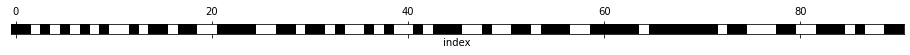

In [277]:
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap="gray_r")
plt.xlabel('index')
plt.yticks(());

#### Ploynomial Regression

In [278]:
measure = 'neg_mean_squared_error'

In [281]:
train_mse = []
test_mse = []
for i in range(1, 6):
    poly = PolynomialFeatures(degree = i)
    x_2 = poly.fit_transform(x_train_selected)
    cv_poly = cross_val_score(LinearRegression(),x_2,Y_train, cv=KFold(n_splits = 3), scoring = measure)
    train_mse.append(-cv_poly.mean())
    
    lg = LinearRegression().fit(x_2, Y_train)
    pred = lg.predict(poly.fit_transform(x_test_selected))
    test_mse.append(np.sum(np.power(pred - Y_test, 2)))

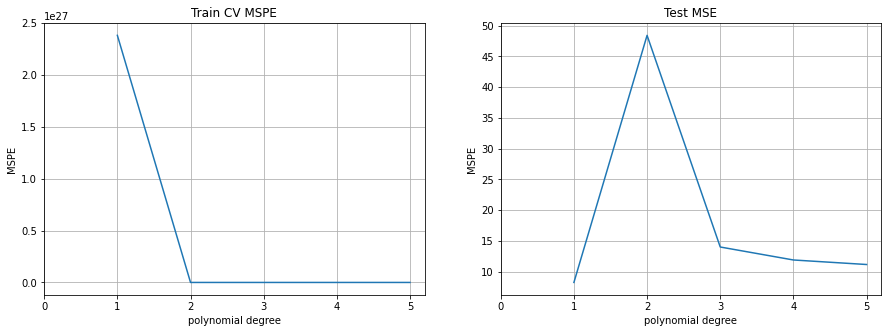

In [282]:
x = [i for i in range(1,6)]

fig = plt.figure(figsize=(15, 5))


plt.subplot(1,2,1)
plt.plot(x, train_mse)

x_range = range(0,6)
y_range = range(0,6)
plt.xticks(x_range, y_range)
plt.title('Train CV MSPE')
plt.xlabel('polynomial degree')
plt.ylabel('MSPE')
plt.grid()

plt.subplot(1,2,2)
plt.plot(x, test_mse)

x_range = range(0,6)
y_range = range(0,6)
plt.xticks(x_range, y_range)
plt.title('Test MSE')
plt.xlabel('polynomial degree')
plt.ylabel('MSPE')
plt.grid()

### Classification

In [122]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [124]:
train_dataset_cat = pd.read_pickle('train_dataset.pkl')
train_dataset_cat.y = train_dataset_cat.y.apply(lambda x: 1 if x > 0 else -1)
test_dataset_cat = pd.read_pickle('test_dataset.pkl')
test_dataset_cat.y = test_dataset_cat.y.apply(lambda x: 1 if x > 0 else -1)
train_dataset_cat

,y,Married,Citizenship_Canada,Citizenship_India,Citizenship_New Zealand,Citizenship_People's Republic of China,Citizenship_Philippines,Citizenship_South Africa,Citizenship_United Kingdom,Citizenship_United States of America,...,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,0,0,0,0,0,0,0,0,1,...,-0.109202,0.035659,0.061705,0.003643,0.049141,-0.143553,0.051251,0.002531,0.228867,-0.036256
1,-1,1,0,1,0,0,0,0,0,0,...,-0.074969,-0.068368,-0.093736,0.012557,-0.044266,-0.006748,-0.061262,0.010832,-0.054845,-0.080655
2,-1,1,0,1,0,0,0,0,0,0,...,-0.074969,-0.068368,-0.093736,0.012557,-0.044266,-0.006748,-0.061262,0.010832,-0.054845,-0.080655
3,-1,1,0,1,0,0,0,0,0,0,...,-0.074969,-0.068368,-0.093736,0.012557,-0.044266,-0.006748,-0.061262,0.010832,-0.054845,-0.080655
4,-1,1,0,1,0,0,0,0,0,0,...,-0.074969,-0.068368,-0.093736,0.012557,-0.044266,-0.006748,-0.061262,0.010832,-0.054845,-0.080655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1,0,0,0,0,0,0,0,0,1,...,0.007590,-0.007681,-0.001397,0.051224,-0.034508,-0.094676,-0.034771,-0.047515,0.025450,0.062095
176,-1,0,0,0,0,0,0,0,0,1,...,0.007590,-0.007681,-0.001397,0.051224,-0.034508,-0.094676,-0.034771,-0.047515,0.025450,0.062095
177,1,0,0,0,0,0,0,1,0,0,...,0.005973,-0.004308,-0.028627,0.004967,-0.024404,-0.020084,0.099232,-0.021327,-0.030075,0.024714
178,1,1,1,0,0,0,0,0,0,0,...,-0.055982,0.046342,0.031989,-0.001134,-0.014343,0.026615,-0.002581,0.023300,0.001334,-0.014302


In [125]:
X_train = train_dataset_cat.values[:,1:]
Y_train = train_dataset_cat.values[:,0]
X_test = test_dataset_cat.values[:,1:]
Y_test = test_dataset_cat.values[:,0]

#### Feature Selection

In [126]:
from sklearn.feature_selection import SelectPercentile

In [127]:
select = SelectPercentile(percentile=90)
select.fit(X_train, Y_train)
x_train_selected = select.transform(X_train)
x_test_selected = select.transform(X_test)
pd.DataFrame(x_train_selected)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.000763,-0.109202,0.035659,0.061705,0.003643,-0.143553,0.051251,0.002531,0.228867,-0.036256
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.083498,-0.074969,-0.068368,-0.093736,0.012557,-0.006748,-0.061262,0.010832,-0.054845,-0.080655
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.083498,-0.074969,-0.068368,-0.093736,0.012557,-0.006748,-0.061262,0.010832,-0.054845,-0.080655
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.083498,-0.074969,-0.068368,-0.093736,0.012557,-0.006748,-0.061262,0.010832,-0.054845,-0.080655
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.083498,-0.074969,-0.068368,-0.093736,0.012557,-0.006748,-0.061262,0.010832,-0.054845,-0.080655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.051482,0.007590,-0.007681,-0.001397,0.051224,-0.094676,-0.034771,-0.047515,0.025450,0.062095
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.051482,0.007590,-0.007681,-0.001397,0.051224,-0.094676,-0.034771,-0.047515,0.025450,0.062095
177,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.009492,0.005973,-0.004308,-0.028627,0.004967,-0.020084,0.099232,-0.021327,-0.030075,0.024714
178,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.092715,-0.055982,0.046342,0.031989,-0.001134,0.026615,-0.002581,0.023300,0.001334,-0.014302


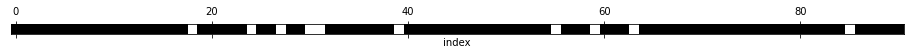

In [128]:
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap="gray_r")
plt.xlabel('index')
plt.yticks(());

#### SVM

In [211]:
from sklearn.svm import SVC

In [142]:
svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma='auto'))
svc.fit(x_train_selected, Y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='auto',
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [143]:
svc.score(x_train_selected, Y_train)

0.9777777777777777

In [144]:
svc.score(x_test_selected, Y_test)

0.4875

In [145]:
pre = []
for c in range(1,21):
    svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=c, gamma='auto'))
    kfold = StratifiedKFold(n_splits=10,random_state=1)
    result = cross_val_score(svc,x_train_selected,Y_train,cv=kfold,scoring="precision")
    pre.append(result.mean())

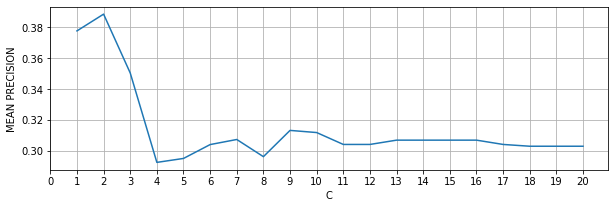

In [146]:
fig = plt.figure(figsize=(10,3))
plt.plot([x for x in range(1, 21)], pre)
x_range = range(0,21)
y_range = range(0,21)
plt.xlabel('C')
plt.ylabel('MEAN PRECISION')
plt.xticks(x_range, y_range)
plt.grid()

Good resource for SVM:

https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py

In [147]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(x_train_selected, Y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 10000000.0, 'gamma': 1e-09} with a score of 0.57


In [148]:
svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma']))
svc.fit(x_train_selected, Y_train)
svc.score(x_test_selected, Y_test)

0.5125

In [149]:
y_pred = svc.predict(x_test_selected)
pd.DataFrame(confusion_matrix(Y_test, y_pred), index=svc.classes_, columns=svc.classes_)

,-1.0,1.0
-1.0,8,33
1.0,6,33


In [150]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print(f"Precision = {tp/(tp+fp):0.3f}")
print(f"Recall = {tp/(tp+fn):0.3f}")

Precision = 0.500
Recall = 0.846


#### Random Forest

ref: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74#:~:text=%20Hyperparameter%20Tuning%20the%20Random%20Forest%20in%20Python,we%20only%20have%20a%20vague%20idea...%20More%20

In [197]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [200]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [202]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

rf_random.fit(x_train_selected, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   23.8s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [208]:
print("The best parameters are %s\n with a score of %0.2f"
      % (rf_random.best_params_, rf_random.best_score_))

The best parameters are {'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
 with a score of 0.52


In [209]:
y_pred = rf_random.best_estimator_.predict(x_test_selected)
pd.DataFrame(confusion_matrix(Y_test, y_pred), index=[-1, 1], columns=[-1, 1])

,-1,1
-1,20,21
1,14,25


In [210]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print(f"Precision = {tp/(tp+fp):0.3f}")
print(f"Recall = {tp/(tp+fn):0.3f}")

Precision = 0.543
Recall = 0.641


#### XGBoosting

ref: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [212]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [268]:
def modelfit(alg, x, y, x_test, y_test, param = None, cv_folds=10):
    
    if param is not None:
        grid_search = GridSearchCV(alg, param, scoring='neg_log_loss',cv=10,n_jobs=-1)
        result = grid_search.fit(x, y)
        best = grid_search.best_estimator_
    else:
        result = alg.fit(x, y)
        best = alg
    
    #Predict training set:
    y_pred = best.predict(x_test)
        
    #Print model report:
    df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=[-1, 1], columns=[-1, 1])
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"Precision = {tp/(tp+fp):0.3f}")
    print(f"Recall = {tp/(tp+fn):0.3f}")
    
    return df

In [269]:
xgb1 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 n_jobs=-1,
 scale_pos_weight=1,
 seed=27)
y_train = [0 if y == -1 else 1 for y in Y_train]
y_test = [0 if y == -1 else 1 for y in Y_test]
modelfit(xgb1, x_train_selected, y_train, x_test_selected, y_test)

Precision = 0.500
Recall = 0.615


,-1,1
-1,17,24
1,15,24


In [270]:
grid_param = {
 'gamma':[i/10.0 for i in range(0,5)],    
 'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 scale_pos_weight=1,
 n_jobs=-1,
 seed=27)

y_train = [0 if y == -1 else 1 for y in Y_train]
y_test = [0 if y == -1 else 1 for y in Y_test]
modelfit(xgb2, x_train_selected, y_train, x_test_selected, y_test, grid_param)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Precision = 0.529
Recall = 0.692


,-1,1
-1,17,24
1,12,27


#### Neural Network

ref: https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594

In [151]:
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Accuracy
from keras.utils import np_utils
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split

In [152]:
from keras.optimizers import SGD

In [153]:
x_train, x_test, y_train, y_test = train_test_split(x_train_selected, Y_train, test_size=0.2,random_state=42)

In [154]:
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
metrics_cat = 'binary_accuracy'
metrics_reg = 'mae'

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [156]:
input_dim = len(x_train_selected[0])

# model = Sequential()
# model.add(Dense(100, activation='relu', input_shape=(input_dim,)))# input_shape = reshape for 13 features 
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1))

# model.compile(optimizer = sgd, loss = 'mse', metrics=[metrics_reg]) #root-mean-square, mae='mean absolute error'
# history = model.fit(x_train, y_train, epochs = epochs, batch_size=1, validation_data=(x_test, y_test))

##
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(input_dim,)))# input_shape = reshape for 13 features 
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer=sgd, 
              loss='categorical_crossentropy', 
              metrics=[metrics_cat])
y_train = [0 if y == -1 else 1 for y in y_train]
y_train2 = to_categorical(y_train)
y_test = [0 if y == -1 else 1 for y in y_test]
y_test2 = to_categorical(y_test)
history = model.fit(x_train, y_train2, epochs = epochs, batch_size=1, validation_data=(x_test, y_test2))
##


Train on 144 samples, validate on 36 samples
Epoch 1/20
144/144 [==============================] - 0s 1ms/step - loss: 0.0123 - binary_accuracy: 0.9931 - val_loss: 1.4980e-04 - val_binary_accuracy: 1.0000
Epoch 2/20
144/144 [==============================] - 0s 583us/step - loss: 7.7235e-05 - binary_accuracy: 1.0000 - val_loss: 1.2553e-04 - val_binary_accuracy: 1.0000
Epoch 3/20
144/144 [==============================] - 0s 556us/step - loss: 6.6518e-05 - binary_accuracy: 1.0000 - val_loss: 1.1184e-04 - val_binary_accuracy: 1.0000
Epoch 4/20
144/144 [==============================] - 0s 563us/step - loss: 5.9981e-05 - binary_accuracy: 1.0000 - val_loss: 1.0311e-04 - val_binary_accuracy: 1.0000
Epoch 5/20
144/144 [==============================] - 0s 569us/step - loss: 5.5538e-05 - binary_accuracy: 1.0000 - val_loss: 9.7014e-05 - val_binary_accuracy: 1.0000
Epoch 6/20
144/144 [==============================] - 0s 576us/step - loss: 5.2278e-05 - binary_accuracy: 1.0000 - val_loss: 9.1982

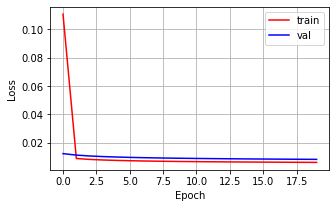

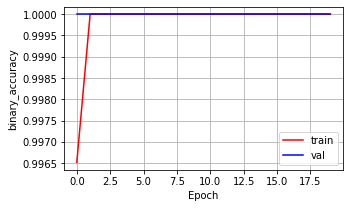

In [159]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.legend()
ax.grid()
ax.tick_params()

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(np.sqrt(history.history[metrics_cat]), 'r', label='train')
ax.plot(np.sqrt(history.history[f'val_{metrics_cat}']), 'b' ,label='val')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(metrics_cat)
ax.legend()
ax.grid()
ax.tick_params()

In [161]:
y_pred = model.predict(x_train_selected)
# y_pred = [1 if y >= 0 else -1 for y in y_pred]
y_pred = [np.argmax(y)*2-1 for y in y_pred]
pd.DataFrame(confusion_matrix(Y_train, y_pred), index=[-1, 1], columns=[-1, 1])

,-1,1
-1,0,81
1,0,99


In [162]:
# loss, acc = model.evaluate(x_test_selected, Y_test,verbose=0) 
y_t = to_categorical([0 if y == -1 else 1 for y in Y_test])
loss, acc = model.evaluate(x_test_selected, y_t, verbose=0)
print(f"Test Loss ={loss}\nTest Accuracy = {acc}")

Test Loss =5.708759021759033
Test Accuracy = 0.48750001192092896


In [163]:
y_pred = model.predict(x_test_selected)
# y_pred = [1 if y >= 0 else -1 for y in y_pred]
y_pred = [np.argmax(y)*2-1 for y in y_pred]
pd.DataFrame(confusion_matrix(Y_test, y_pred), index=[-1, 1], columns=[-1, 1])

,-1,1
-1,0,41
1,0,39


In [164]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print(f"Precision = {tp/(tp+fp):0.3f}")
print(f"Recall = {tp/(tp+fn):0.3f}")

Precision = 0.487
Recall = 1.000


#### Models Comparison

In [113]:
models = []
models.append(('KNN',KNeighborsClassifier()))
models.append(('Tree',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC(kernel='rbf',gamma=3)))

In [118]:
names = []
results = []
means = []
sdevs = []
scoring = 'roc_auc'

In [119]:
for name,model in models:
    kfold = StratifiedKFold(n_splits=3,random_state=1)
    cv_results = cross_val_score(model,X2,Y,cv=kfold,scoring=scoring)
    results.append(cv_results)
    means.append(cv_results.mean())
    sdevs.append(cv_results.std())
    names.append(name)

In [122]:
df1 = pd.DataFrame()
df1['name'] = names
df1[f'mean {scoring}'] = means
df1[f'{scoring} std dev'] = sdevs
df1

,name,mean accuracy,roc_auc std dev
0,KNN,0.565812,0.054491
1,Tree,0.480053,0.057326
2,NB,0.514329,0.049321
3,SVM,0.430082,0.041701


Text(0, 0.5, 'Test Accuracy Rate')

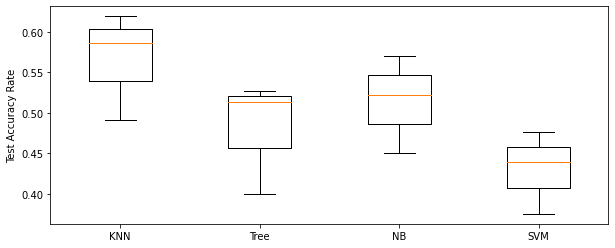

In [123]:
plt.figure(figsize=(10,4))
plt.boxplot(results)
plt.xticks(range(1,5),names)
plt.ylabel(f'Test {scoring} Rate')